In [1]:
import pandas as pd 
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax


import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import torch
import requests
from bs4 import BeautifulSoup
import re

c:\Users\johnh\.virtualenvs\SentimentAnalysisFinance-LKfdupw9\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I don't do this in real life, but I will turn off warnings for readability purposes.

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Data load

In [3]:
df = pd.read_csv('data.csv')
#df = pd.read_csv('df_bert.csv')


In [4]:
df.shape

(5842, 2)

In [5]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [6]:
df.tail()

,Sentence,Sentiment
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral
5841,HELSINKI AFX - KCI Konecranes said it has won ...,positive


## Quick EDA

<Axes: ylabel='Sentiment'>

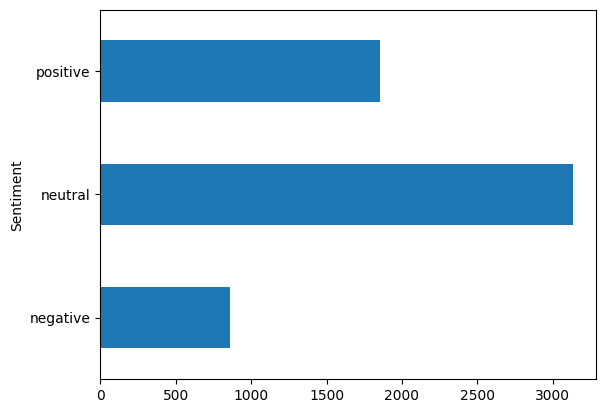

In [7]:
df.groupby('Sentiment')['Sentiment'].count().plot(kind='barh')

## Run Models

### Bert

In [8]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [9]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [10]:
df['sentence_sentiment'] = df['Sentence'].apply(lambda x: sentiment_score(x[:512]))

As estimating sentiment demonstrating time consuming.  I will create another dataset that has the outcomes expected.

In [ ]:
df.to_csv('df_bert.csv', index = False)

In [ ]:
df['sentiment_dummy'] = df['Sentiment'].map({'negative': 1, 'neutral': 2, 'positive': 3})

In [ ]:

df_pivot = pd.pivot_table((df.groupby(['sentence_sentiment','sentiment_dummy']).
                          count().reset_index()), index = 'sentence_sentiment', columns= 'sentiment_dummy',
                          aggfunc='sum', fill_value=0)
df_pivot.columns = [f'{col[0]}_{str(col[1])}' for col in df_pivot.columns.values]
df_pivot = df_pivot.iloc[:,3:].reset_index()
df_pivot['TotalOriginal'] = df_pivot.iloc[:,1:].sum(axis = 1)
totals_rows = pd.DataFrame(df_pivot.sum(axis = 0)).T
df_pivot = df_pivot.reset_index(drop = True)
df_pivot = pd.concat([df_pivot, totals_rows]).reset_index(drop = True)
df_pivot.loc[df_pivot.index[-1], 'sentence_sentiment'] = 'TotalBERTSentiment'
df_pivot.set_index('sentence_sentiment', inplace = True)

df_pivot.iloc[:,:].style.background_gradient(cmap='viridis')



,Sentiment_1,Sentiment_2,Sentiment_3,TotalOriginal
sentence_sentiment,,,,
1,618,1156,817,2591
2,129,212,79,420
3,64,349,166,579
4,30,668,256,954
5,19,745,534,1298
TotalBERTSentiment,860,3130,1852,5842


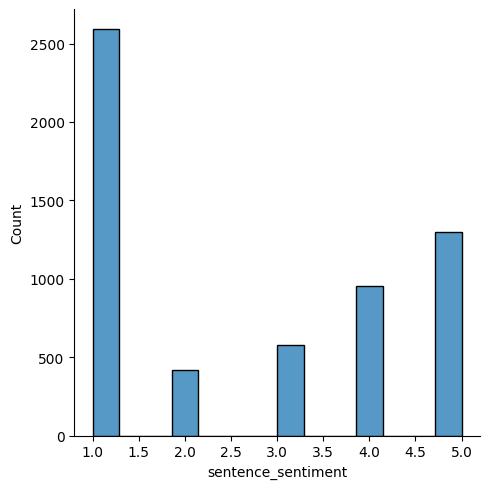

In [ ]:
sns.displot(df, x="sentence_sentiment")

### VADER Sentiment

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johnh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
def get_vader_polarity(df):

    vader_ = {}
    for num, text in enumerate(df['Sentence']):
        vader_[num] = sia.polarity_scores(text[:512])
    vaders_= pd.DataFrame(vader_).T
    vaders_.columns = [f'vader_'+ col for col in vaders_.columns]
    df = pd.merge(df, vaders_, left_index=True, right_index=True)


    return df


In [ ]:
df = get_vader_polarity(df)
df.head()

,Sentence,Sentiment,sentence_sentiment,sentiment_dummy,vader_neg,vader_neu,vader_pos,vader_compound
0,The GeoSolutions technology will leverage Bene...,positive,5,3,0.000,0.847,0.153,0.5423
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,1,1,0.167,0.833,0.000,-0.2023
2,"For the last quarter of 2010 , Componenta 's n...",positive,1,3,0.064,0.856,0.080,0.1531
3,According to the Finnish-Russian Chamber of Co...,neutral,1,2,0.000,1.000,0.000,0.0000
4,The Swedish buyout firm has sold its remaining...,neutral,1,2,0.000,1.000,0.000,0.0000


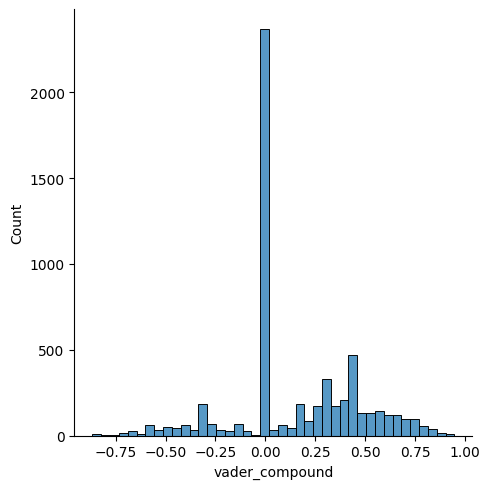

In [ ]:
sns.displot(df, x="vader_compound")

In [ ]:
df['vader_compound_sent'] = pd.cut(df['vader_compound'], bins= 3, labels = ['negative', 'neutral', 'positive'])
df['vader_compound_dummy'] = df['vader_compound_sent'].map({'negative': 1, 'neutral': 2, 'positive': 3})
df.head()

,Sentence,Sentiment,sentence_sentiment,sentiment_dummy,vader_neg,vader_neu,vader_pos,vader_compound,vader_compound_sent,vader_compound_dummy
0,The GeoSolutions technology will leverage Bene...,positive,5,3,0.000,0.847,0.153,0.5423,positive,3
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,1,1,0.167,0.833,0.000,-0.2023,neutral,2
2,"For the last quarter of 2010 , Componenta 's n...",positive,1,3,0.064,0.856,0.080,0.1531,neutral,2
3,According to the Finnish-Russian Chamber of Co...,neutral,1,2,0.000,1.000,0.000,0.0000,neutral,2
4,The Swedish buyout firm has sold its remaining...,neutral,1,2,0.000,1.000,0.000,0.0000,neutral,2


In [ ]:
df_pivot = df.groupby(['sentence_sentiment','vader_compound_dummy']).count().reset_index()
df_pivot = df_pivot.loc[:, ['sentence_sentiment', 'vader_compound_dummy', 'Sentence']].copy()
df_pivot = pd.pivot_table(df_pivot, index = 'sentence_sentiment', columns= 'vader_compound_dummy',
                          aggfunc='sum', fill_value=0)
df_pivot.columns = [f'vader_{str(col[1])}' for col in df_pivot.columns.values]
df_pivot['TotalOriginal'] = df_pivot.sum(axis = 1)
df_pivot.index = df_pivot.index.astype(str)
totals_rows = pd.DataFrame(df_pivot.sum(axis = 0)).T
df_pivot = df_pivot.reset_index(drop = False)
df_pivot = pd.concat([df_pivot, totals_rows]).reset_index(drop = True)
df_pivot.loc[df_pivot.index[-1], 'sentence_sentiment'] = 'TotalVADERSentiment'
df_pivot.set_index('sentence_sentiment', inplace = True)

df_pivot.iloc[:,:].style.background_gradient(cmap='viridis')


,vader_1,vader_2,vader_3,TotalOriginal
sentence_sentiment,,,,
1,376,1475,740,2591
2,111,247,62,420
3,41,407,131,579
4,34,628,292,954
5,28,787,483,1298
TotalVADERSentiment,590,3544,1708,5842


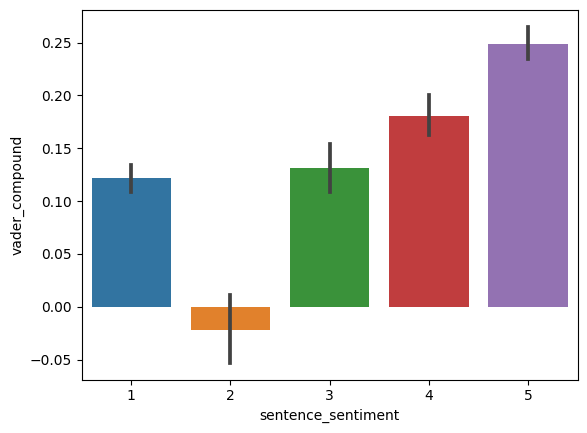

In [ ]:
sns.barplot(data=df, x='sentence_sentiment', y='vader_compound')
plt.show()

### ROBERTA Sentiment

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(f"cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained(f"cardiffnlp/twitter-roberta-base-sentiment")


In [ ]:
def roberta_sentiment_scores(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    scores = torch.softmax(result.logits[0], dim=0).tolist()
    
    # Calculate the compound sentiment score using a weighted sum
    compound_score = (scores[2] - scores[0])  # Positive - Negative
    
    
    scores_dict = {
        'neg': scores[0],
        'neu': scores[1],
        'pos': scores[2],
        'compound': compound_score
    }

    return scores_dict

In [ ]:
tokens = tokenizer.encode('This is great!', return_tensors='pt')
result = model(tokens)

scores = torch.softmax(result.logits[0], dim=0).tolist()
compound_score = (scores[2] - scores[0])  # Positive - Negative
    
scores_dict = {
        'neg': scores[0],
        'neu': scores[1],
        'pos': scores[2],
        'compound': compound_score
}

In [ ]:
scores_dict

{'neg': 0.0017200466245412827,
 'neu': 0.010140222497284412,
 'pos': 0.9881397485733032,
 'compound': 0.9864197019487619}

In [ ]:
def get_roberta_polarity(df):

    roberta_ = {}
    for num, text in enumerate(df['Sentence']):
        roberta_[num] = roberta_sentiment_scores(text[:512])
    robertas_= pd.DataFrame(roberta_).T
    
    robertas_.columns = [f'roberta_'+ col for col in robertas_.columns]
    df = pd.merge(df, robertas_, left_index=True, right_index=True)


    return df

In [ ]:
df = get_roberta_polarity(df)

In [ ]:
#df.head()

In [ ]:
df.to_csv('data_bert_vader_roberta.csv', index = False)

In [ ]:
#df = pd.read_csv('data_bert_vader_roberta.csv')

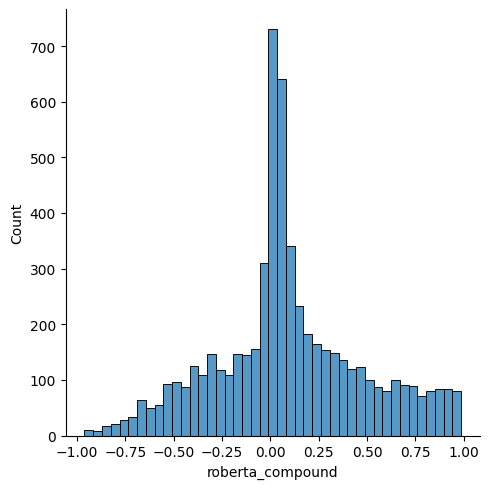

In [ ]:
sns.displot(df, x="roberta_compound")

In [ ]:
df['roberta_compound_sent'] = pd.cut(df['roberta_compound'], bins= 3, labels = ['negative', 'neutral', 'positive'])
df['roberta_compound_dummy'] = df['roberta_compound_sent'].map({'negative': 1, 'neutral': 2, 'positive': 3})
df.head()

,Sentence,Sentiment,sentence_sentiment,sentiment_dummy,vader_neg,vader_neu,vader_pos,vader_compound,vader_compound_sent,vader_compound_dummy,roberta_neg,roberta_neu,roberta_pos,roberta_compound,roberta_compound_sent,roberta_compound_dummy
0,The GeoSolutions technology will leverage Bene...,positive,5,3,0.000,0.847,0.153,0.5423,positive,3,0.004404,0.349696,0.645900,0.641496,positive,3
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,1,1,0.167,0.833,0.000,-0.2023,neutral,2,0.143034,0.810581,0.046385,-0.096648,neutral,2
2,"For the last quarter of 2010 , Componenta 's n...",positive,1,3,0.064,0.856,0.080,0.1531,neutral,2,0.151266,0.711913,0.136821,-0.014445,neutral,2
3,According to the Finnish-Russian Chamber of Co...,neutral,1,2,0.000,1.000,0.000,0.0000,neutral,2,0.114385,0.822406,0.063209,-0.051175,neutral,2
4,The Swedish buyout firm has sold its remaining...,neutral,1,2,0.000,1.000,0.000,0.0000,neutral,2,0.073200,0.902309,0.024490,-0.048710,neutral,2


In [ ]:


df_pivot = df.groupby(['sentence_sentiment','roberta_compound_dummy']).count().reset_index()
df_pivot = df_pivot.loc[:, ['sentence_sentiment', 'roberta_compound_dummy', 'Sentence']].copy()
df_pivot = pd.pivot_table(df_pivot, index = 'sentence_sentiment', columns= 'roberta_compound_dummy',
                          aggfunc='sum', fill_value=0)
df_pivot.columns = [f'roberta_{str(col[1])}' for col in df_pivot.columns.values]
df_pivot['TotalOriginal'] = df_pivot.sum(axis = 1)
df_pivot.index = df_pivot.index.astype(str)
totals_rows = pd.DataFrame(df_pivot.sum(axis = 0)).T
df_pivot = df_pivot.reset_index(drop = False)
df_pivot = pd.concat([df_pivot, totals_rows]).reset_index(drop = True)
df_pivot.loc[df_pivot.index[-1], 'sentence_sentiment'] = 'TotalROBERTASentiment'
df_pivot.set_index('sentence_sentiment', inplace = True)

df_pivot.iloc[:,:].style.background_gradient(cmap='viridis')


,roberta_1,roberta_2,roberta_3,TotalOriginal
sentence_sentiment,,,,
1,578,1663,350,2591
2,166,205,49,420
3,65,382,132,579
4,19,671,264,954
5,10,703,585,1298
TotalROBERTASentiment,838,3624,1380,5842


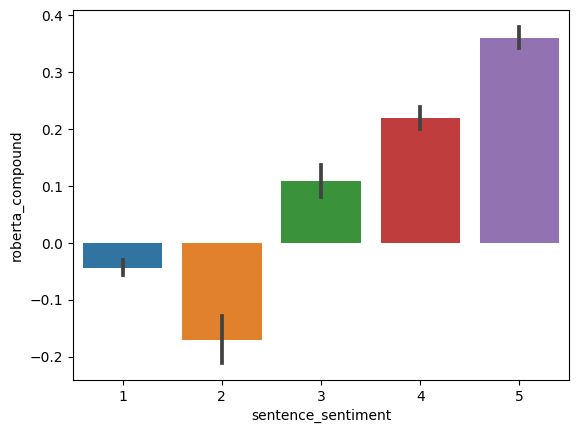

In [ ]:
sns.barplot(data=df, x='sentence_sentiment', y='roberta_compound')
plt.show()

### Compare Methods

In [ ]:
approaches_mask = ['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg',
                   'roberta_neu', 'roberta_pos']

I just commented out as it takes over 6 minutes to run, each time.

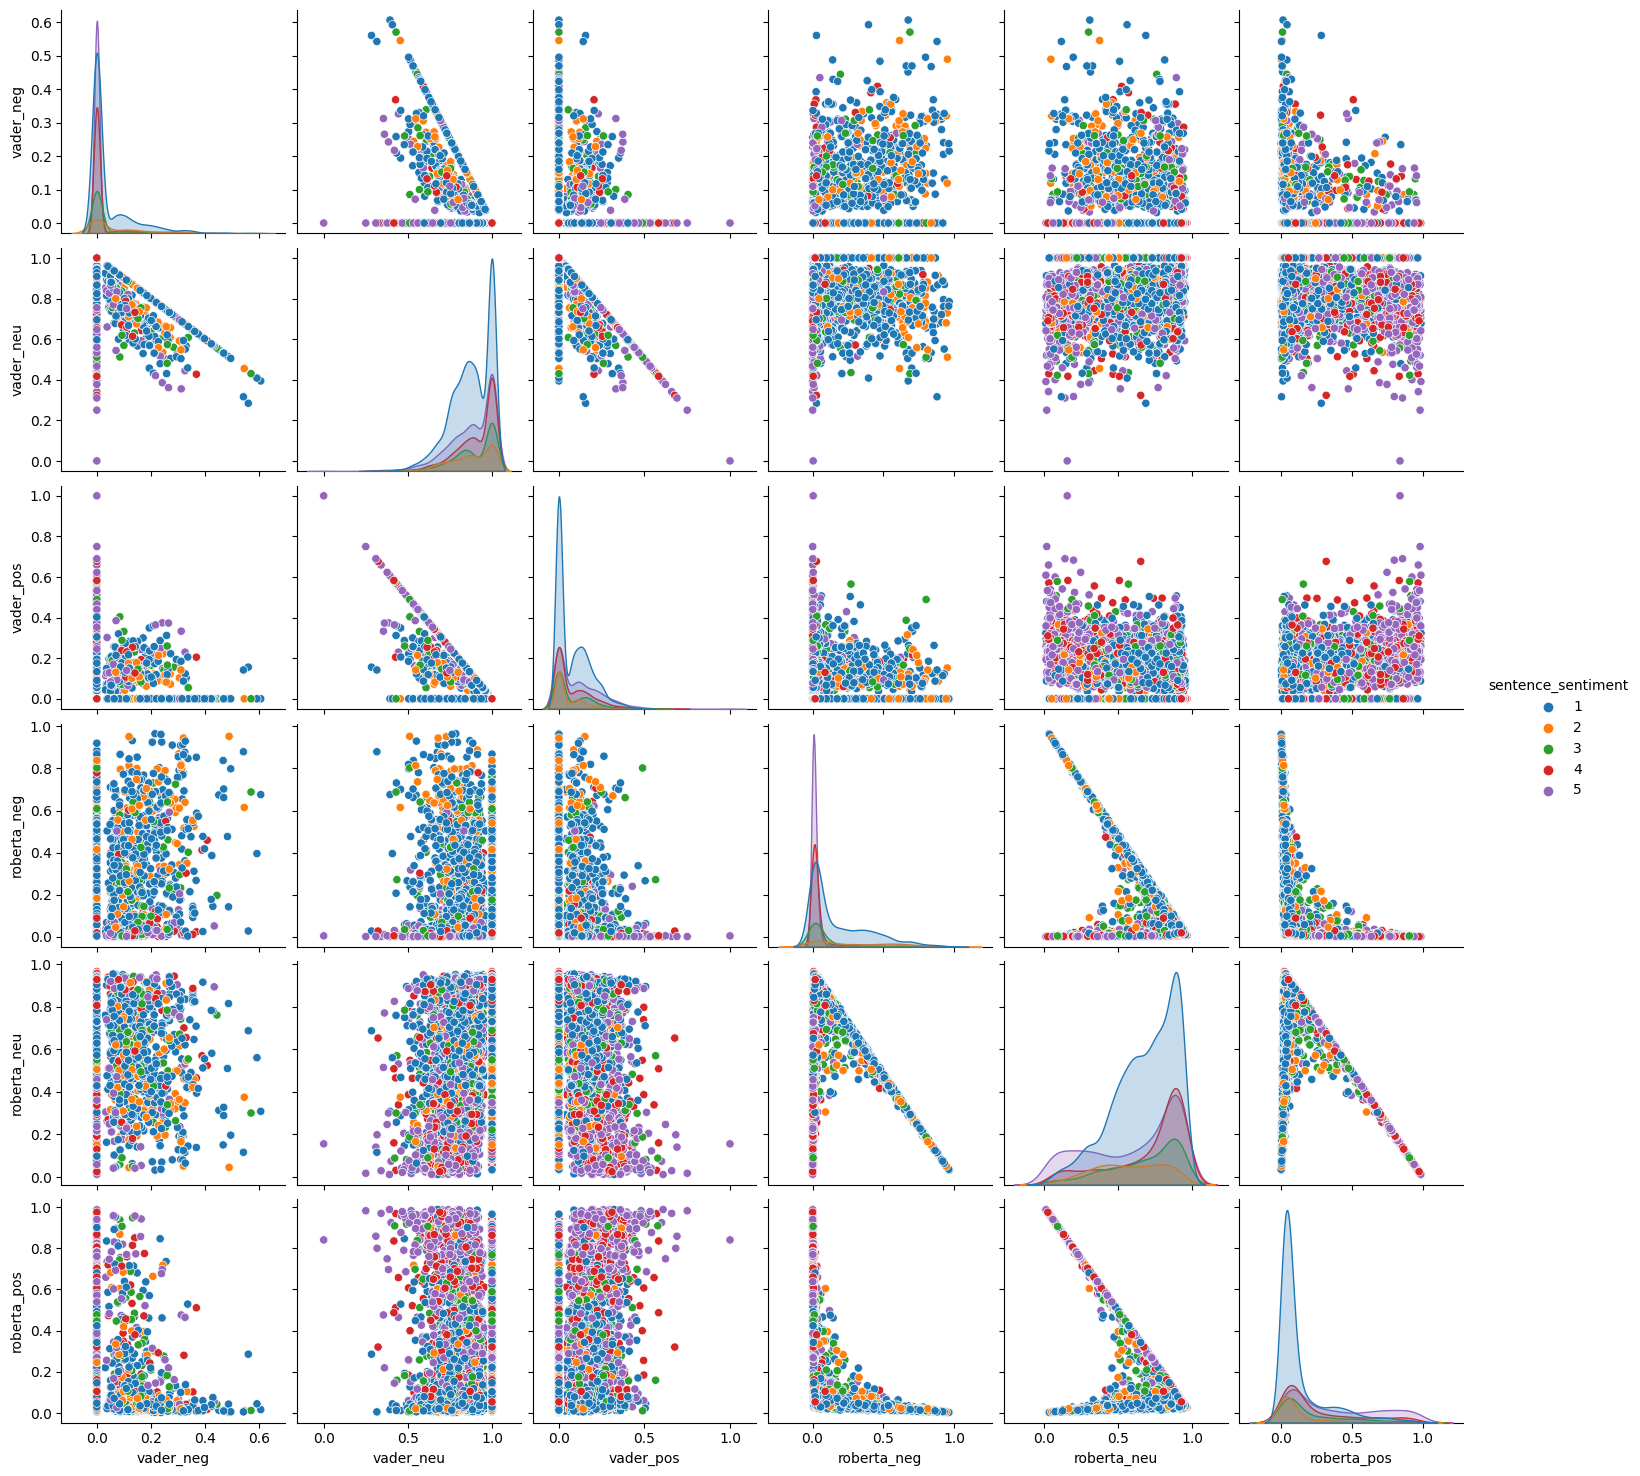

In [ ]:
sns.pairplot(data=df,
             vars=approaches_mask,
            hue='sentence_sentiment',
            palette='tab10')

plt.show()